In [ ]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae, confusion_matrix as cm, classification_report, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Name, Ticket, and Fare likely don't contribute to survival predictions, and would be difficult to set up numerically for the model. The only reason fare would matter is to compare the relative class of people embarking, but the Pclass field is a much better metric for this purpose.

The Embarked feature would be interesting to keep, to see if certain regions were better. There are only three possibilities for this field, and so I can one-hot encode these into three new columns. Lastly, the cabin would also likely contribute to the survival rates, were there an easy way to make the data numerical.

I'll start by ignoring cabin for now, and making all the adjustments mentioned above.

In [ ]:
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'] # Features to keep
data = train.loc[:, features] # New frame with desired features
data['Cherbourg'] = (train.Embarked == 'C').astype(int) # One-hot encoding for embarking location
data['Queenstown'] = (train.Embarked == 'Q').astype(int)
data['Southampton'] = (train.Embarked == 'S').astype(int)
data.Sex = data.Sex.map(lambda p: 0 if p == 'male' else 1) # Numerical encoding of male/female

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Cherbourg    891 non-null    int64  
 7   Queenstown   891 non-null    int64  
 8   Southampton  891 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 62.8 KB


There are still some null entries in the Age column. There is a relatively small amount, I think in the long-term I will try two approaches and compare the results. First will be imputation of missing values. Second, dropping the null rows. Lastly, a regressor to predict age based on available metrics.

In [ ]:
imputer = SimpleImputer()
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed,
                           columns = data.columns)

data_dropped = data.dropna(axis=0)

I'll take a closer look at the cabin feature to see if it is usable in any capacity:

In [ ]:
print(train.Cabin.isna().value_counts(), '\n ~~~~~~~~~')
train.Cabin.value_counts()

True     687
False    204
Name: Cabin, dtype: int64 
 ~~~~~~~~~


B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

I'd first like to check if there is any correlation between the deck of the passenger, and the Pclass feature. To do this, I will strip the deck of the first Cabin string for each row, and use this to compare agains the passenger class.

In [ ]:
deck = train.Cabin.astype(str).map(lambda p: p.split(' ')[0][0]) # Strip the deck from the string
non_na_cabins = deck != 'n' # If there are any passengers who were split between multiple decks, this will not account for that.
deck.value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

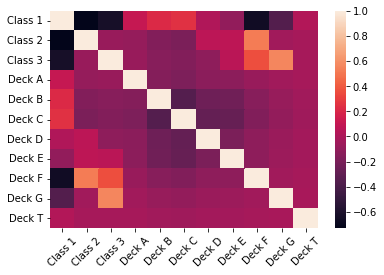

In [ ]:
corr_data = pd.DataFrame() # Empty frame to use for correlation data

for Pclass in [1,2,3]: # Iterate over the three passenger classes
    corr_data[f'Class {str(Pclass)}'] = (train.Pclass.loc[non_na_cabins] == Pclass).astype(int) # One-hot encode the data
for deck_ in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']:  # Iterate over possible decks
    corr_data[f'Deck {deck_}'] = (deck == deck_).astype(int) # One-hot encode the data

corr = corr_data.corr() # Plot the correlation matrix and do some formatting
ax = sns.heatmap(corr)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45);

It looks like there is some correlation, though it is not discrete. First class passengers were more often situated around decks A, B, and C. Second class were on decks D, E, and F. Lastly, third class were on decks E, F, and G. Deck T was likely a technical crew deck due to the very low passenger count, and the large jump in alphabetical order (A quick Google search confirms that the T deck was used for engine and boiler crew). There is definitely some dependence between the deck and the passenger class, however, I am unsure whether removing one or the other would be beneficial.

Due to the large number of missing cabin information, I will elect to drop the Cabin feature entirely. Nearly 80% of the data is missing a Cabin value. Combined with the relative correlation between Deck and Pclass, I feel this is a safe course of action. Since the Cabin feature was not pulled into the above data earlier, no extra work is necessary at this point.

In [ ]:
data_imputed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cherbourg,Queenstown,Southampton
0,0.0,3.0,0.0,22.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,38.0,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,1.0,26.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,35.0,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,0.0,35.0,0.0,0.0,0.0,0.0,1.0


At this point, the imputed data contains all numerical values, no missing or NaN. The last step is to scale the data for use in the training model.

In [ ]:
print((data_imputed < 0).any()) # Nothing is negative, that's good

Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Cherbourg      False
Queenstown     False
Southampton    False
dtype: bool


In [ ]:
print((data_dropped < 0).any()) # Nothing is negative, that's good

Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Cherbourg      False
Queenstown     False
Southampton    False
dtype: bool


Using two separate scalers for each data approach:

In [ ]:
imputed_scaler = MinMaxScaler()
data_imp_scl = pd.DataFrame(imputed_scaler.fit_transform(data_imputed))
data_imp_scl.columns = data_imputed.columns

dropped_scaler = MinMaxScaler()
data_drp_scl = pd.DataFrame(dropped_scaler.fit_transform(data_dropped))
data_drp_scl.columns = data_dropped.columns


In [ ]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']


X_imp = data_imp_scl[features]
y_imp = data_imp_scl['Survived']
X_dr = data_drp_scl[features]
y_dr = data_drp_scl['Survived']
"""
X_imp = data_imputed[features]
y_imp = data_imputed['Survived']
X_dr = data_dropped[features]
y_dr = data_dropped['Survived']
"""
X_tr_imp , X_te_imp, y_tr_imp, y_te_imp = train_test_split(X_imp, y_imp)
X_tr_drp , X_te_drp, y_tr_drp, y_te_drp = train_test_split(X_dr, y_dr)



In [ ]:
print(X_tr_imp.shape)
print(y_tr_imp.shape)

(668, 5)
(668,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier


def eval_model(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pr = model.predict(X_te).astype(int)
    print(classification_report(y_te, y_pr, zero_division=0))
    return

models = {'KNN': KNeighborsClassifier(),
          'Radius Neighbors': RadiusNeighborsClassifier(radius=2), 
          'SGD Classifier': SGDClassifier(),
          'Support Vector Machine': SVC(),
          'Gaussian Classifier': GaussianProcessClassifier(),
          'Decision Tree Classifier': DecisionTreeClassifier()}

for model in models.keys():
    print(model)
    np.random.seed(31415) # Set the random seed every time for reproducible results to compare
    eval_model(models[model], X_tr_imp, X_te_imp, y_tr_imp, y_te_imp)



KNN
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83       149
         1.0       0.66      0.73      0.69        74

    accuracy                           0.78       223
   macro avg       0.76      0.77      0.76       223
weighted avg       0.79      0.78      0.79       223

Radius Neighbors
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80       149
         1.0       0.00      0.00      0.00        74

    accuracy                           0.67       223
   macro avg       0.33      0.50      0.40       223
weighted avg       0.45      0.67      0.54       223

SGD Classifier
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       149
         1.0       0.68      0.70      0.69        74

    accuracy                           0.79       223
   macro avg       0.76      0.77      0.76       223
weighted avg       0.79      0.79     

The Decision Tree, KNN, and SVC algorithms performed in the top bracket based on F1 score. I will pick these three to move forward. Next I want to compare the performance of imputation versus dropping, as well as the performance of StandardScaler vs MinMaxScaler.

In [ ]:
models = {'KNN' : KNeighborsClassifier(),
          'Tree': DecisionTreeClassifier(),
          'SVC' : SVC()}

print('Dropped Values')
for model in models.keys():
    print(model)
    np.random.seed(31415)
    eval_model(models[model], X_tr_drp, X_te_drp, y_tr_drp,  y_te_drp)



Dropped Values
KNN
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80       103
         1.0       0.72      0.76      0.74        76

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Tree
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       103
         1.0       0.74      0.76      0.75        76

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

SVC
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       103
         1.0       0.83      0.75      0.79        76

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83   

When compared to the above results, the dropped values perform strongly ahead of the imputed values, particularly for the SVC algorithm. I will continue with this one:

In [ ]:
from sklearn.model_selection import GridSearchCV
svm_model = SVC(random_state = 31415)

params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

clf = GridSearchCV(svm_model, params)
model = clf.fit(X_tr_drp, y_tr_drp)

y_pr_drp = model.predict(X_te_drp)
print(model.best_estimator_)
print(classification_report(y_te_drp, y_pr_drp))

SVC(C=100, gamma=1, random_state=31415)
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       103
         1.0       0.80      0.74      0.77        76

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



This didn't offer a significant improvement, and the parameters are blowing up. I will stop here, and take the 77% f1 score.